In [1]:
import pathlib
from importlib import reload
import numpy as np
import torch
import matplotlib.pyplot as plt

import lab3
reload(lab3)

import lab3.classes
reload(lab3.classes)
import lab3.classes as cs

import lab3.show
reload(lab3.show)
from lab3.show import display_img_with_masks, display_masks, display_img_with_masks_nouveau

import lab3.trans
reload(lab3.trans)
from lab3.trans import validation_trans, train_trans, test_trans

import lab3.dataset
reload(lab3.dataset)
from lab3.dataset import FiftyOneDataset

import lab3.net
reload(lab3.net)
from lab3.net import Net

import lab1.device
reload(lab1.device)
from lab1.device import device

import lab3.util as lu
reload(lab3.util)
from lab3.util import seconds_to_time, pickle_data

device

device(type='mps')

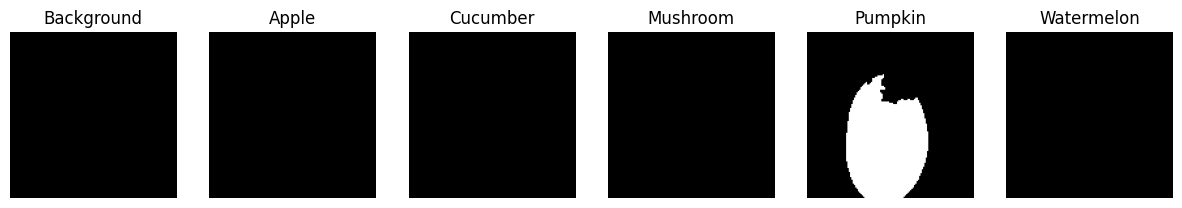

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.992157].


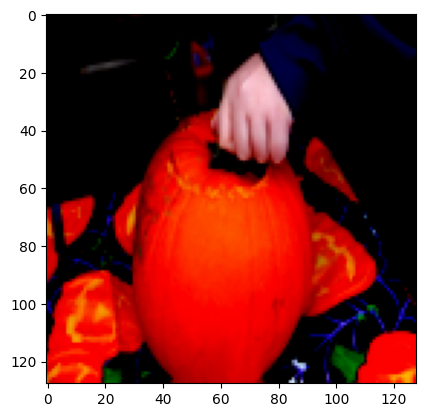

In [3]:
import torch
import torch.utils.data as tud
from torchvision.tv_tensors import Mask, Image
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2 import functional as F

import lab3.util as lu
import lab3.dataset
reload(lab3.dataset)
from lab3.dataset import FiftyOneDataset

train_dataset = FiftyOneDataset('data-lab3-dyi/train.pkl', train_trans, split = 'train')
test_dataset = FiftyOneDataset('data-lab3-dyi/test.pkl', test_trans, split = 'test')
valid_dataset = FiftyOneDataset('data-lab3-dyi/valid.pkl', validation_trans, split = 'validation')

num_workers = 6 # M3 Pro
# num_workers = 8 # M1
batch_size = 512

train_ld = tud.DataLoader(
  train_dataset,
  batch_size = batch_size,
  num_workers = num_workers,
  shuffle = True,
  collate_fn = lu.unzipListIntoList
)
valid_ld = tud.DataLoader(
  valid_dataset,
  batch_size = batch_size,
  num_workers = num_workers,
  shuffle = False,
  collate_fn = lu.unzipListIntoList
)

# print(f'Train: {len(train_dataset)}, Test: {len(valid_dataset)}')

img = test_dataset[0][0]
masks = test_dataset[0][1]

display_img_with_masks_nouveau(img, masks, cs.classes)

In [4]:
from statistics import mean
from sklearn.metrics import f1_score
from torch import tensor as t, concat as c

ZERO = torch.zeros(0, 6, 128, 128) < 1

class Stats:
  length = 0
  
  dice: float = 0
  iou:  float  = 0
  f1_micro: float = 0
  f1_macro: float = 0
  
  loss_acum: list[float] = []
  
  def init(self):
    pass
  
  def add_data(self, ys: torch.Tensor, y_hats: torch.Tensor, loss: float):
    # print(f"TYPE: {type(ys)}")
    # print(f"LEN:  {ys}")
    self.length += ys.shape[0]
    self.loss_acum.append(loss)

    intersection = torch.bitwise_and(ys, y_hats)
    union = torch.bitwise_or(ys, y_hats)

    intersection = torch.sum(intersection)
    union = torch.sum(union)

    # Jaccard = || A \intersect B || / || A \union B ||
    iou = intersection / union

    # DICE = 2 || A \intersect B || / (||A|| + ||B||)
    dice = 2 * intersection / (torch.sum(ys) + torch.sum(y_hats))

    # Flatten the tensors
    ys_flat = ys.view(-1).numpy()
    y_hats_flat = y_hats.view(-1).numpy()

    # Calculate Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(ys_flat, y_hats_flat, average='micro')
    macro_f1 = f1_score(ys_flat, y_hats_flat, average='macro')
    
    self.iou  += iou.item()
    self.dice += dice.item()
    self.f1_macro += macro_f1.item()
    self.f1_micro += micro_f1.item()
  
  def get_stats(self):
    return (
      self.iou / self.length, 
      self.dice / self.length,
      self.f1_micro / self.length,
      self.f1_macro / self.length,
      mean(self.loss_acum)
    )

def run_epoch(model: Net,
              loader: torch.utils.data.DataLoader,
              loss_fn, optimizer):
  stats = Stats()
  IS_TRAIN = optimizer is not None
  
  if IS_TRAIN:
    model.train()
  else:
    model.eval()

  ix = -1
  for images, true_masks in loader:
    # print('A' * 50)
    # print(images)
    # print('B' * 40)
    # print(true_masks)
    # print('C' * 40)
    # print(type(images))
    # print(type(true_masks))
    # print('A' * 50)
      
    images = torch.stack(images).to(device)
    true_masks = torch.stack(true_masks).to(device)
    
    if not IS_TRAIN:
      with torch.no_grad():
        predictions = model(images)
    else:
      predictions = model(images)
      

    loss = loss_fn(true_masks, predictions)

    # print(f"  PRED_MAX: {predictions.max()}")
    predictions = predictions > 0.5
    true_masks = true_masks > 0.5
    stats.add_data(true_masks.cpu().detach(), predictions.cpu().detach(), loss.cpu().detach().item())
    
    if IS_TRAIN:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    if ix == 0:
      break
    ix -= 1
  
  ret = stats.get_stats()
  return ret


In [5]:
from datetime import datetime

def train_and_eval(model, train_ld, valid_ld, epoch_count = 10, learning_rate = 1e-3):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  start_time = datetime.now()

  train_loss_acum  = []
  train_iou_acum   = []
  train_dice_acum  = []
  train_micro_acum = []
  train_macro_acum = []
  valid_loss_acum  = []
  valid_iou_acum   = []
  valid_dice_acum  = []
  valid_micro_acum = []
  valid_macro_acum = []
  
  for epoch in range(epoch_count):
    print(f'EPOCH: {epoch + 1} / {epoch_count}')
    train_iou, train_dice, train_micro, train_macro, train_loss = run_epoch(model, train_ld, loss_func, optimizer)
    
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'  train      | Elapsed: {elapsed}')

    valid_iou, valid_dice, valid_micro, valid_macro, valid_loss = run_epoch(model, valid_ld, loss_func, optimizer)
    
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'  valid      | Elapsed: {elapsed}')

    train_iou_acum.append(train_iou)
    train_dice_acum.append(train_dice)
    train_micro_acum.append(train_micro)
    train_macro_acum.append(train_macro)
    train_loss_acum.append(train_loss)
    
    valid_iou_acum.append(valid_iou)
    valid_dice_acum.append(valid_dice)
    valid_micro_acum.append(valid_micro)
    valid_macro_acum.append(valid_macro)
    valid_loss_acum.append(valid_loss)

    print(f'  Training Loss:  {train_loss},  Validation Loss:  {valid_loss}')
    print(f'  Training IoU:   {train_iou},   Validation IoU:   {valid_iou}')
    print(f'  Training Dice:  {train_dice},  Validation Dice:  {valid_dice}')
    print(f'  Training Micro: {train_micro}, Validation Micro: {valid_micro}')
    print(f'  Training Macro: {train_macro}, Validation Macro: {valid_macro}')

  return train_iou_acum, valid_iou_acum, train_dice_acum, valid_dice_acum, train_micro_acum, valid_micro_acum, train_macro_acum, valid_macro_acum, train_loss_acum, valid_loss_acum

In [6]:
def plot(train, valid, label = "IoU"):
  plt.clf()
  plt.plot(train, 'b', label = f'Training {label}')
  plt.plot(valid, 'r', label = f'Validation {label}')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

In [ ]:
model = Net(train_dataset[0][0].shape[0], num_classes = cs.num_classes).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

EPOCHS = 100

train_iou, valid_iou, train_dice, valid_dice, train_micro, valid_micro, train_macro, valid_macro, train_loss, valid_loss = train_and_eval(model, train_ld, valid_ld, epoch_count = EPOCHS, learning_rate = 1e-3)


Parameter count: 1,928,582
EPOCH: 1 / 100
  train      | Elapsed: 5m14s
  valid      | Elapsed: 5m45s
  Training Loss:  0.021086251363158226,  Validation Loss:  0.030606459081172942
  Training IoU:   0.0,   Validation IoU:   1.3847289711480165e-07
  Training Dice:  0.0,  Validation Dice:  2.7693976955132406e-07
  Training Micro: 0.0019000367738483531, Validation Micro: 0.006103670385731293
  Training Macro: 0.0009649657452824995, Validation Macro: 0.0031169971157896928
EPOCH: 2 / 100
  train      | Elapsed: 13m44s
  valid      | Elapsed: 14m40s
  Training Loss:  0.026250752102997568,  Validation Loss:  0.030301885120570658
  Training IoU:   2.2440717746612076e-07,   Validation IoU:   4.560177089871874e-05
  Training Dice:  4.4870636046135924e-07,  Validation Dice:  9.055521078170485e-05
  Training Micro: 0.0019000152567509164, Validation Micro: 0.006105823004329748
  Training Macro: 0.0009651846862616996, Validation Macro: 0.0031626770357604662
EPOCH: 3 / 100


In [ ]:
iter = train_ld.__iter__()
img: torch.Tensor; mask: torch.Tensor; prediction: torch.Tensor
imgs, masks = next(iter)

# prediction = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0) img.shape, mask.unique(), mask.max()
# for i in range(10):
#   print(masks[0].max())

In [ ]:
plot(train_iou, valid_iou)
plot(train_dice, valid_dice, label = "dice")
plot(train_micro, valid_micro, label = "micro")
plot(train_macro, valid_macro, label = "macro")
plot(train_loss, valid_loss, label = "loss")


In [ ]:
torch.save(model, 'lab3/net_attempt2.pt')

In [ ]:
model = torch.load('lab3/net_attempt2.pt').to(device)

img, true_mask = valid_dataset[40]
prediction = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)

true_mask  = true_mask > .5
prediction = prediction > .5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize= (7, 7))
display_img_with_masks(ax1, img, true_mask)
display_img_with_masks(ax2, img, prediction)
display_masks(ax3, true_mask)
display_masks(ax4, prediction)

# (
#   torch.max(true_mask),
#   torch.max(prediction),
# )
# (
#   torch.count_nonzero(true_mask),
# ),(
#   torch.count_nonzero(true_mask != .0),
#   (true_mask != .0).float()[0,0,0]
# )
# prediction.shape

In [ ]:
# t1 = t(
# # batch
# [
#   # masks for img 1
#   [
#     # mask for class 1
#     [[.2, .1], [.1, .3]],
#     # mask for class 2
#     [[.2, .1], [.1, .3]],
#     # mask for class 3
#     [[.2, .1], [.1, .3]],
#   ],
#   # masks for img 2
#   [
#     [[.2, .1], [.1, .5]],
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .3]],
#   ],
#   # masks for img 3
#   [
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .3]],
#   ]
# ])
# 
# 
# # values, indices = t1.max(t([0, 2]))
# # (
# #   t1,
# #   values,
# #   (values ** (-1)) #.repeat(3) #.reshape((2, 3)) * t1
# # )
# 
# BATCH_SIZE = t(t1.shape)[0]
# CLASS_NO = t(t1.shape)[1]
# DIM = t(t1.shape)[2]
# 
# vals, ix = t1.max(dim = -1)[0].max(dim = -1)[0].max(dim = -1)
# vals = vals ** -1
# t2 = vals.repeat_interleave(CLASS_NO * DIM * DIM).view((BATCH_SIZE, CLASS_NO, DIM, DIM))
# (
#   # vals.repeat(CLASS_NO).reshape((CLASS_NO, 2)).transpose(dim0 = 0, dim1 = 1)
#     # .repeat((2, 3))
#   # vals.repeat(t1.shape)
#   t(t1.shape),
#   (BATCH_SIZE, CLASS_NO, DIM, DIM),
#   # vals.repeat(t(t1.shape)[:-1].flipud().tolist()).shape
#   vals,
#   BATCH_SIZE * CLASS_NO * DIM * DIM,
#   t(t1.shape).prod(),
#   t1 * t2,
#   # vals.repeat_interleave(BATCH_SIZE * CLASS_NO * DIM * DIM).shape,
#     # vals.repeat_interleave(t(t1.shape).tolist()).shape
#   # t1 * vals
#   # t1 * vals.repeat_interleave(BATCH_SIZE * CLASS_NO * DIM * DIM).view((2, 3, 2, 2, 2)),
#   # (t2 / t1)
#   # t2 / t1
# )